# 이미지 증강(Image Augmentation)을 사용하여 CNN 학습

> # Overfitting 대응책

In [1]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [2]:
import tensorflow as tf

tf.__version__

'2.10.0'

# I. wget From Github
* 'dogs_and_cats_small.zip' 파일 다운로드

In [3]:
# !wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2023-01-26 01:28:42--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M   289MB/s    in 0.3s    

2023-01-26 01:28:43 (289 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [4]:
# !ls -l 

total 88500
-rw-r--r-- 1 root root 90618980 Jan 26 01:28 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 24 14:38 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [5]:
# !unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [6]:
# !ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Jan 26 01:28 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 24 14:38 sample_data
drwxr-xr-x 4 root root     4096 Jan 26 01:28 test
drwxr-xr-x 4 root root     4096 Jan 26 01:28 train
drwxr-xr-x 4 root root     4096 Jan 26 01:28 validation


> ## 2) <font color = 'red'>[Optional]</font> Image Augmentation Test

* rotation_range = 40: 0도 ~ 40도 범위에서 임의로 이미지 회전
* width_shift_range = 0.2: -20% ~ +20% 범위에서 이미지 좌우 이동
* height_shift_range = 0.2: -20% ~ +20% 범위에서 이미지 상하 이동
* shear_range = 0.2: 최대 20% 비율로 시계 반대방향으로 기울어져 변형
* zoom_range = 0.2: 80%에서 120% 범위에서 이미지 확대/축소
* horizontal_flip = True: 임의로 이미지 수평방향 뒤집기
* vertical_flip = True: 임의로 이미지 수직방향 뒤집기
* brightness_range = [0.5, 1.5]: -50% ~ +50% 범위에서 이미지 밝기 조절
* fill_mode = 'nearest': 주변 픽셀로 이미지 채우기

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             brightness_range = [0.5, 1.5],
                             fill_mode = 'nearest')

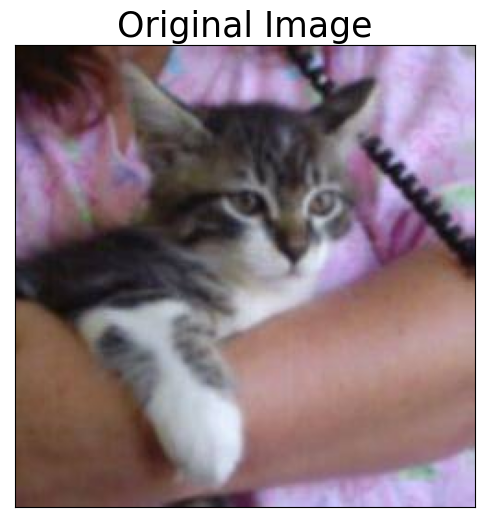

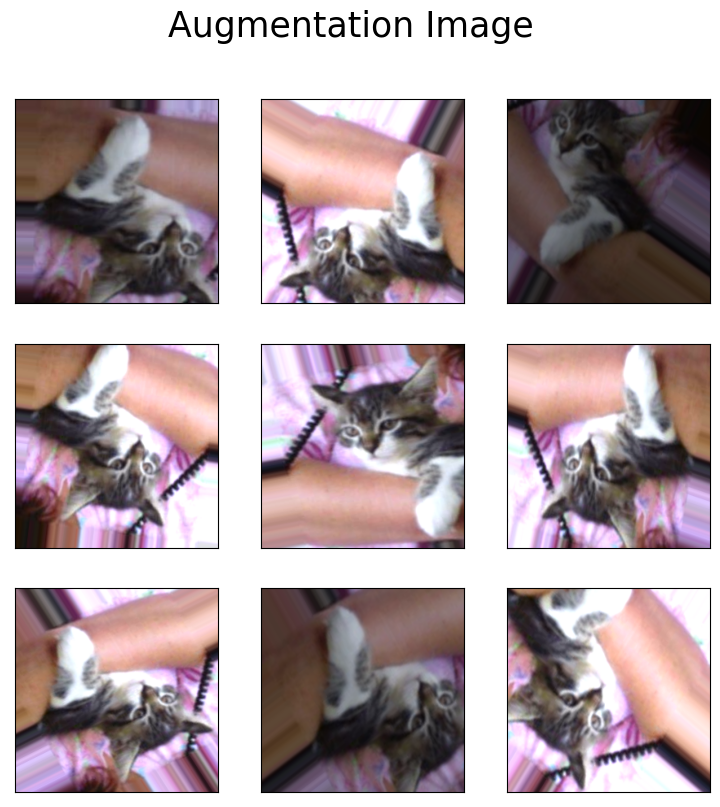

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pandas as np

CAT = img_to_array(load_img('./../../../secret/example_data/15_DL/dogs_and_cats_small/train/cats/cat.168.jpg')).astype(int)
plt.figure(figsize = (6, 6))
plt.xticks([])
plt.yticks([])
plt.title('Original Image', fontsize = 25)
plt.imshow(CAT)


CAT = CAT.reshape((1, ) + CAT.shape)
train_generator = datagen.flow(CAT, batch_size = 1)

fig = plt.figure(figsize = (9, 9))
fig.suptitle('Augmentation Image', fontsize = 25)
for i in range(9):
    data = next(train_generator)
    image = data[0]
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(image, dtype = int))
plt.show()

# II. Data Preprocessing

> ## 1) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [5]:
train_dir = './../../../secret/example_data/15_DL/dogs_and_cats_small/train'
valid_dir = './../../../secret/example_data/15_DL/dogs_and_cats_small/validation'
test_dir  = './../../../secret/example_data/15_DL/dogs_and_cats_small/test'

> ## 2) ImageDataGenerator( ) & flow_from_directory( )

* Normalization & Augmentation
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   brightness_range = [0.5, 1.5],
                                   fill_mode = 'nearest')

# Without Augmentation 
valid_datagen = ImageDataGenerator(rescale = 1./255)



# With Augmentation
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

# Without Augmentation
valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# III. CNN Keras Modeling

> ## 1) Model Define

* Feature Extraction & Classification
 * Dropout Layer

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

> ## 2) Model Compile

* 모델 학습방법 설정

In [9]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 32분
 * epochs : 60 -> 100

In [10]:
# %%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 10s 68ms/step - loss: 0.6940 - accuracy: 0.5110 - val_loss: 0.6912 - val_accuracy: 0.5100
Epoch 2/100
100/100 [==============================] - 7s 66ms/step - loss: 0.6924 - accuracy: 0.5080 - val_loss: 0.6902 - val_accuracy: 0.5290
Epoch 3/100
100/100 [==============================] - 7s 67ms/step - loss: 0.6886 - accuracy: 0.5340 - val_loss: 0.6908 - val_accuracy: 0.5160
Epoch 4/100
100/100 [==============================] - 7s 67ms/step - loss: 0.6901 - accuracy: 0.5370 - val_loss: 0.6928 - val_accuracy: 0.5090
Epoch 5/100
100/100 [==============================] - 7s 67ms/step - loss: 0.6866 - accuracy: 0.5235 - val_loss: 0.6802 - val_accuracy: 0.5870
Epoch 6/100
100/100 [==============================] - 7s 67ms/step - loss: 0.6742 - accuracy: 0.5385 - val_loss: 0.6918 - val_accuracy: 0.5110
Epoch 7/100
100/100 [==============================] - 7s 66ms/step - loss: 0.6699 - accuracy: 0.5820 - val_loss: 0.6799 - val_accuracy

100/100 [==============================] - 7s 67ms/step - loss: 0.5109 - accuracy: 0.7560 - val_loss: 0.5660 - val_accuracy: 0.7060
Epoch 58/100
100/100 [==============================] - 7s 68ms/step - loss: 0.5322 - accuracy: 0.7355 - val_loss: 0.5270 - val_accuracy: 0.7300
Epoch 59/100
100/100 [==============================] - 7s 69ms/step - loss: 0.5082 - accuracy: 0.7435 - val_loss: 0.5416 - val_accuracy: 0.7220
Epoch 60/100
100/100 [==============================] - 7s 68ms/step - loss: 0.4961 - accuracy: 0.7585 - val_loss: 0.5274 - val_accuracy: 0.7440
Epoch 61/100
100/100 [==============================] - 7s 68ms/step - loss: 0.5084 - accuracy: 0.7470 - val_loss: 0.5153 - val_accuracy: 0.7370
Epoch 62/100
100/100 [==============================] - 7s 67ms/step - loss: 0.5017 - accuracy: 0.7490 - val_loss: 0.5202 - val_accuracy: 0.7420
Epoch 63/100
100/100 [==============================] - 7s 67ms/step - loss: 0.5058 - accuracy: 0.7510 - val_loss: 0.5567 - val_accuracy: 0.733

KeyboardInterrupt: 

> ## 4) 학습 결과 시각화

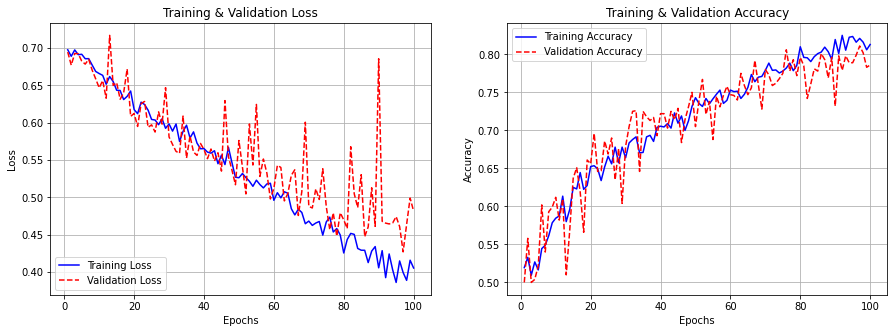

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* test_generator

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [17]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50, 
                                verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.48629
Accuracy = 0.79700


# 
# 
# 
# The End
# 
# 
# 